# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
#conda install -c conda-forge ipywidgets


In [3]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])


# Create training set and define training dataloader
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


# Split the training set into training and validation sets
train_size = int(0.8 * len(train_set))
validation_size = len(train_set) - train_size
train_set, validation_set = torch.utils.data.random_split(train_set, [train_size, validation_size])


train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=True)


# Create test set and define test dataloader
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I chose the transforms.ToTensor() transform to convert the image data to a tensor format because deep learning models typically operate on tensors. The transforms.Normalize() transform was used to standardize the pixel values and normalizing the input data and improving model performance. These preprocessing steps are commonly applied to images in deep learning tasks.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


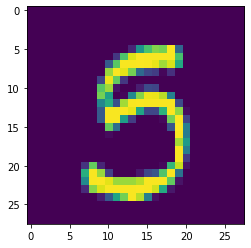

1


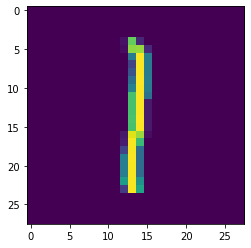

8


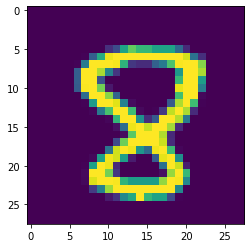

9


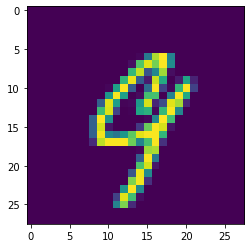

6


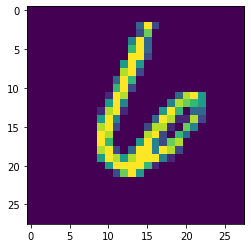

In [5]:
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# the model
model = NeuralNetwork()

# the loss function
criterion = nn.CrossEntropyLoss()

# the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
num_epochs = 10

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Zero out the gradients of the optimizer
        optimizer.zero_grad()

        # Get the outputs of your model and compute your loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Compute the loss gradient using the backward method and have the optimizer take a step
        loss.backward()
        optimizer.step()

        # Compute the accuracy and print the accuracy and loss
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))

    # The validation step
    val_loss = 0.0
    val_correct = 0
    model.eval()
    for inputs, labels in validation_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 28.40% training loss: 0.37368
Epoch 1 validation accuracy: 35.95% validation loss: 0.24320
Epoch 2 training accuracy: 30.23% training loss: 0.17972
Epoch 2 validation accuracy: 36.44% validation loss: 0.20081
Epoch 3 training accuracy: 30.65% training loss: 0.13539
Epoch 3 validation accuracy: 36.69% validation loss: 0.17278
Epoch 4 training accuracy: 30.86% training loss: 0.11332
Epoch 4 validation accuracy: 36.67% validation loss: 0.18080
Epoch 5 training accuracy: 31.02% training loss: 0.09664
Epoch 5 validation accuracy: 37.01% validation loss: 0.14203
Epoch 6 training accuracy: 31.14% training loss: 0.08519
Epoch 6 validation accuracy: 36.90% validation loss: 0.15173
Epoch 7 training accuracy: 31.20% training loss: 0.07791
Epoch 7 validation accuracy: 37.06% validation loss: 0.13708
Epoch 8 training accuracy: 31.27% training loss: 0.07064
Epoch 8 validation accuracy: 37.05% validation loss: 0.13613
Epoch 9 training accuracy: 31.29% training loss: 0.06542

Plot the training loss (and validation loss/accuracy, if recorded).

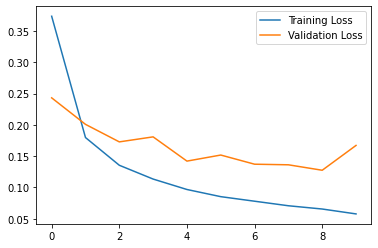

In [9]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 95.78%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [11]:
class NewNN(nn.Module):
    def __init__(self):
        super(NewNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# the model
model = NewNN()

# the loss function
criterion = nn.CrossEntropyLoss()

# the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 15

In [13]:
## YOUR CODE HERE ##

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Zero out the gradients of the optimizer
        optimizer.zero_grad()

        # Get the outputs of your model and compute your loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Compute the loss gradient using the backward method and have the optimizer take a step
        loss.backward()
        optimizer.step()

        # Compute the accuracy and print the accuracy and loss
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))

    # The validation step
    val_loss = 0.0
    val_correct = 0
    model.eval()
    for inputs, labels in validation_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 26.77% training loss: 0.61942
Epoch 1 validation accuracy: 34.48% validation loss: 0.42680
Epoch 2 training accuracy: 29.11% training loss: 0.30839
Epoch 2 validation accuracy: 35.06% validation loss: 0.34641
Epoch 3 training accuracy: 29.66% training loss: 0.25221
Epoch 3 validation accuracy: 35.70% validation loss: 0.28561
Epoch 4 training accuracy: 30.02% training loss: 0.21237
Epoch 4 validation accuracy: 36.11% validation loss: 0.24583
Epoch 5 training accuracy: 30.34% training loss: 0.17886
Epoch 5 validation accuracy: 36.29% validation loss: 0.22228
Epoch 6 training accuracy: 30.57% training loss: 0.15409
Epoch 6 validation accuracy: 36.50% validation loss: 0.19490
Epoch 7 training accuracy: 30.75% training loss: 0.13313
Epoch 7 validation accuracy: 36.71% validation loss: 0.17290
Epoch 8 training accuracy: 30.93% training loss: 0.11610
Epoch 8 validation accuracy: 36.87% validation loss: 0.15953
Epoch 9 training accuracy: 31.01% training loss: 0.10403

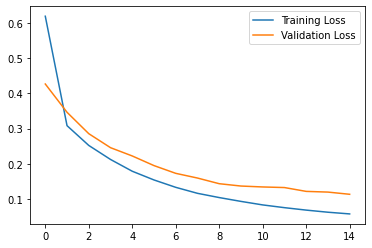

In [14]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

In [15]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.43%


## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
torch.save(model.state_dict(), 'model.pth')

print("Model saved in the current working directory.")

Model saved in the current working directory.
